In [1]:
# Data handling and manipulation
import os,textwrap
import shutil
import json
import io as input_output
import pandas as pd
import numpy as np

# Machine learning and deep learning libraries
import torch
import random
import datasets
import transformers
# import evaluate
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize

# Data augmentation and image processing
import albumentations as A
import cv2
from PIL import Image, UnidentifiedImageError

# Evaluation and metrics
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, f1_score

# Utilities
import requests
import ast
import seaborn as sns
import itertools
import gc
from tqdm import tqdm
from wordcloud import WordCloud
from textwrap import wrap
from pathlib import Path
from datasets import load_dataset
from matplotlib import pyplot as plt
import multiprocessing as mp
from sklearn.model_selection import train_test_split

# Model and training related imports
from transformers import Trainer, TrainingArguments, AutoModel, BlipForConditionalGeneration
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor
from transformers import AutoTokenizer, GPT2Config, default_data_collator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoProcessor, AutoModelForCausalLM

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print(f"We will use the GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using the CPU instead.")

# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Clear CUDA cache
torch.cuda.empty_cache()

# WandB login
import wandb
wandb.login(key="e6e4c8d10c1c73d5cbae270330b5ecb2e2b3944a")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


No GPU available, using the CPU instead.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: husnifadhilah62 (husnifadhilah62-institut-teknologi-bandung). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
is_apply_enhancement = False
is_translate = False
str_filter = None #'chest x-ray'
is_verify_image = False
data_dir = f'/kaggle/input/image-caption-indonesia/'
IMG_DIR = f'{data_dir}Images'

In [3]:
def verify_image(image_path):
    try:
        Image.open(image_path).verify()
        return True
    except UnidentifiedImageError:
        print(f"Error: The file at {image_path} is not a valid image.")
        return False
    except FileNotFoundError:
        print(f"Error: The file at {image_path} was not found.")
        return False
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False

In [4]:
# Pertama, pisahkan menjadi train dan test
df = pd.read_csv('/kaggle/input/image-caption-indonesia/metadata.csv')
df.rename(columns={"file_name": "Images","text": "Caption"}, inplace=True)
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)

# Kemudian, pisahkan temp_df menjadi validation dan testing
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
print(len(df_train),len(df_val),len(df_test))
df

32364 4045 4046


Images                                                                                Caption
0      1000268201_693b08cb0e.jpg               Seorang anak berpakaian merah muda sedang menaiki tangga di jalan masuk.
1      1000268201_693b08cb0e.jpg                                           Seorang gadis memasuki sebuah bangunan kayu.
2      1000268201_693b08cb0e.jpg                                        Seorang gadis kecil naik ke rumah bermain kayu.
3      1000268201_693b08cb0e.jpg                            Seorang gadis kecil menaiki tangga menuju rumah bermainnya.
4      1000268201_693b08cb0e.jpg                         Seorang gadis kecil berpakaian merah muda masuk ke kabin kayu.
...                          ...                                                                                    ...
40450   997722733_0cb5439472.jpg                              Seorang pria berkemeja merah muda memanjat permukaan batu
40451   997722733_0cb5439472.jpg                                   Seorang pria sedang memanjat tebing tinggi di udara.
40452   997722733_0cb5439472.jpg  Seseorang dengan kemeja merah memanjat permukaan batu yang ditutupi pegangan bantuan.
40453   997722733_0cb5439472.jpg                                                 Seorang pemanjat tebing berbaju merah.
40454   997722733_0cb5439472.jpg                             Seorang pemanjat tebing berlatih di dinding panjat tebing.

[40455 rows x 2 columns]

In [5]:
def preprocess_dataset(df,is_translate=False, str_filter=None):
#     df = df.sample(n=5, random_state=42).reset_index(drop=True)
    # df = df.sample(frac=0.003, random_state=42).reset_index(drop=True)
    if str_filter is None:
        df = df.copy()
    else:
        mask = df['Caption'].str.contains(str_filter, case=False)
        df = df[mask].copy()
    if is_translate:
        df['Caption'] = df['Caption'].apply(translate_caption)
    df['Path'] = df['Images'].apply(lambda x: f"{IMG_DIR}/{x}")
    df['caption_length'] = df['Caption'].apply(lambda x: len(str(x)) if x else 0)
    df['num_words'] = df['Caption'].apply(lambda x: len(str(x).split()) if x else 0)
    if is_verify_image:
        df = df[df['Path'].apply(lambda x: os.path.exists(x) and verify_image(x))]
    return df

df_train = preprocess_dataset(df_train,is_translate, str_filter)
df_val = preprocess_dataset(df_val,is_translate, str_filter)
df_test = preprocess_dataset(df_test,is_translate, str_filter)
df_merge = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

In [6]:
print(len(df_merge), len(df_train),len(df_val),len(df_test))
df_train.head()

40455 32364 4045 4046


Images                                                                             Caption                                                                    Path  caption_length  num_words
0   359082432_c1fd5aa2d6.jpg  Seorang pria dan seekor anjing sedang berdiri di atas pohon yang tumbang ke tanah.   /kaggle/input/image-caption-indonesia/Images/359082432_c1fd5aa2d6.jpg              82         14
1  2460799229_ce45a1d940.jpg  Ketiga anak laki-laki yang mengenakan jaket pelampung sedang melihat ke dalam air.  /kaggle/input/image-caption-indonesia/Images/2460799229_ce45a1d940.jpg              82         12
2  3634828052_3b6aeda7d6.jpg     Seorang wanita dengan kamera dengan lensa yang sangat panjang mengambil gambar.  /kaggle/input/image-caption-indonesia/Images/3634828052_3b6aeda7d6.jpg              79         11
3  2216568822_84c295c3b0.jpg               Wanita dengan helm merah dan tato penduduk asli Amerika di lengannya.  /kaggle/input/image-caption-indonesia/Images/2216568822_84c295c3b0.jpg              69         11
4  3080056515_3013830309.jpg                                              Satu orang berbisik kepada orang lain.  /kaggle/input/image-caption-indonesia/Images/3080056515_3013830309.jpg              38          6

In [7]:
df_merge

Images                                                                             Caption                                                                    Path  caption_length  num_words
0       359082432_c1fd5aa2d6.jpg  Seorang pria dan seekor anjing sedang berdiri di atas pohon yang tumbang ke tanah.   /kaggle/input/image-caption-indonesia/Images/359082432_c1fd5aa2d6.jpg              82         14
1      2460799229_ce45a1d940.jpg  Ketiga anak laki-laki yang mengenakan jaket pelampung sedang melihat ke dalam air.  /kaggle/input/image-caption-indonesia/Images/2460799229_ce45a1d940.jpg              82         12
2      3634828052_3b6aeda7d6.jpg     Seorang wanita dengan kamera dengan lensa yang sangat panjang mengambil gambar.  /kaggle/input/image-caption-indonesia/Images/3634828052_3b6aeda7d6.jpg              79         11
3      2216568822_84c295c3b0.jpg               Wanita dengan helm merah dan tato penduduk asli Amerika di lengannya.  /kaggle/input/image-caption-indonesia/Images/2216568822_84c295c3b0.jpg              69         11
4      3080056515_3013830309.jpg                                              Satu orang berbisik kepada orang lain.  /kaggle/input/image-caption-indonesia/Images/3080056515_3013830309.jpg              38          6
...                          ...                                                                                 ...                                                                     ...             ...        ...
40450  2703155733_19ac6f97a8.jpg                        Seorang wanita melepas jubah besar memperlihatkan gaun mewah  /kaggle/input/image-caption-indonesia/Images/2703155733_19ac6f97a8.jpg              60          8
40451   498794783_cc2ac62b47.jpg  Seorang gadis berpakaian sedang meniup gelembung dengan gadis lain di belakangnya.   /kaggle/input/image-caption-indonesia/Images/498794783_cc2ac62b47.jpg              82         11
40452  3317145805_071b15debb.jpg                            Seekor pudel hitam dengan mainan tali merah di mulutnya.  /kaggle/input/image-caption-indonesia/Images/3317145805_071b15debb.jpg              56          9
40453  2418191216_82711d5c5c.jpg                                      Seorang wanita tua memakai topi dan tersenyum.  /kaggle/input/image-caption-indonesia/Images/2418191216_82711d5c5c.jpg              46          7
40454  3163477256_073605e06e.jpg    Seorang kiper berseragam biru menangkap bola sepak oleh pemain berseragam merah.  /kaggle/input/image-caption-indonesia/Images/3163477256_073605e06e.jpg              80         11

[40455 rows x 5 columns]

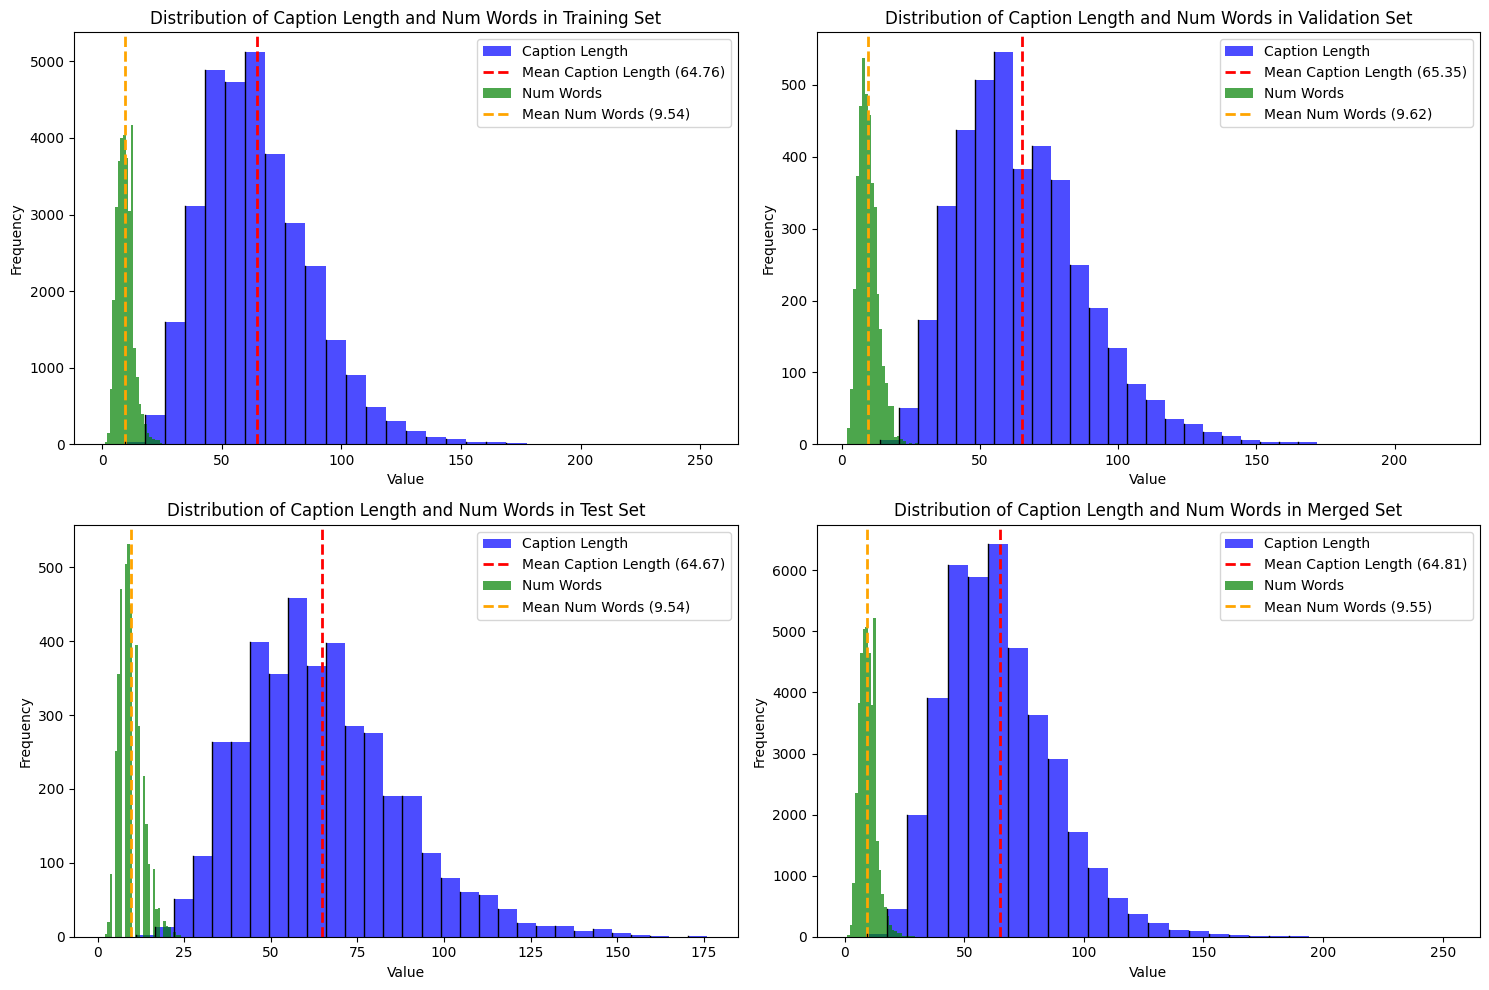

In [8]:
import matplotlib.pyplot as plt

# Assuming df_train, df_val, df_test, df_merge are your dataframes
datasets = [(df_train, 'Training Set'), (df_val, 'Validation Set'), (df_test, 'Test Set'), (df_merge, 'Merged Set')]

# 1. Distribution of captions length and number of words for all datasets
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, (dataset, label) in zip(axs.flatten(), datasets):
    # Calculate mean for caption_length and num_words
    mean_caption_length = dataset['caption_length'].mean()
    mean_num_words = dataset['num_words'].mean()

    # Plot the caption length histogram
    ax.hist(dataset['caption_length'], bins=30, color='blue', alpha=0.7, label='Caption Length')
    ax.axvline(mean_caption_length, color='red', linestyle='dashed', linewidth=2, label=f'Mean Caption Length ({mean_caption_length:.2f})')
    
    # Plot the number of words histogram
    ax.hist(dataset['num_words'], bins=30, color='green', alpha=0.7, label='Num Words')
    ax.axvline(mean_num_words, color='orange', linestyle='dashed', linewidth=2, label=f'Mean Num Words ({mean_num_words:.2f})')

    # Add vertical lines for count values (optional, as per your original code)
    for count, x in zip(*np.histogram(dataset['caption_length'], bins=30)):
        ax.plot([x, x], [0, count], color='black', linewidth=1)

    # Add title, labels, and legend
    ax.set_title(f'Distribution of Caption Length and Num Words in {label}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

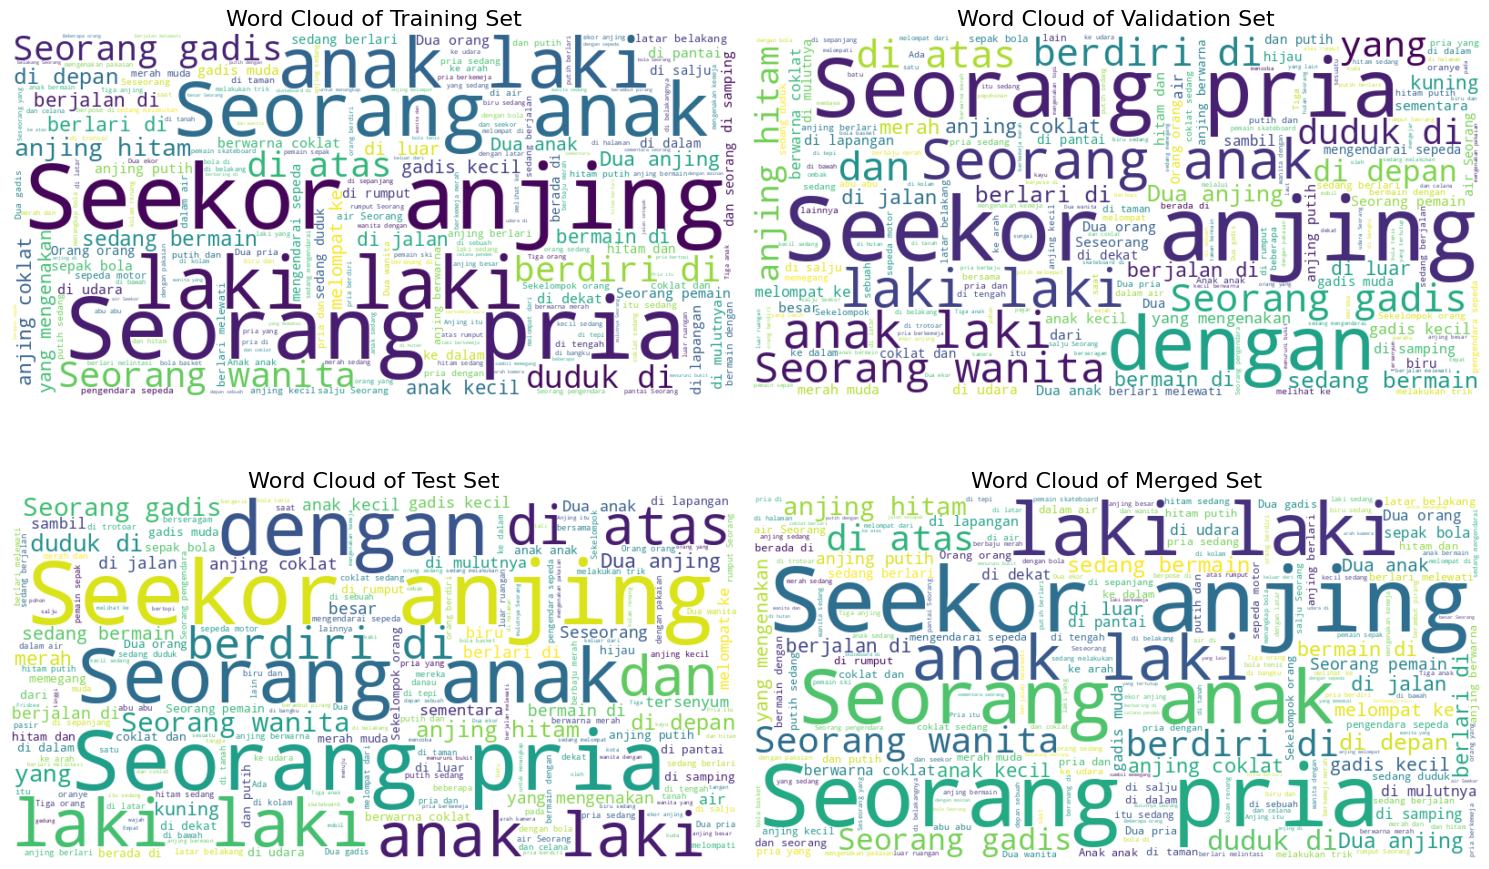

In [9]:
# Subplots for Word Cloud of all datasets (df_train, df_val, df_test, df_merge)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Datasets to generate wordclouds
datasets = [(df_train, "Training Set"), 
            (df_val, "Validation Set"), 
            (df_test, "Test Set"), 
            (df_merge, "Merged Set")]

# Function to generate wordcloud and plot in a specific axis
def plot_wordcloud_ax(dataset, ax, title):
    text = " ".join(caption for caption in dataset['Caption'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    # Plot the wordcloud in the provided ax
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # No axis for wordclouds
    ax.set_title(title, fontsize=16)

# Loop through each dataset and plot the wordcloud in each subplot
for ax, (dataset, label) in zip(axs.flatten(), datasets):
    plot_wordcloud_ax(dataset, ax, f'Word Cloud of {label}')

plt.tight_layout()
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


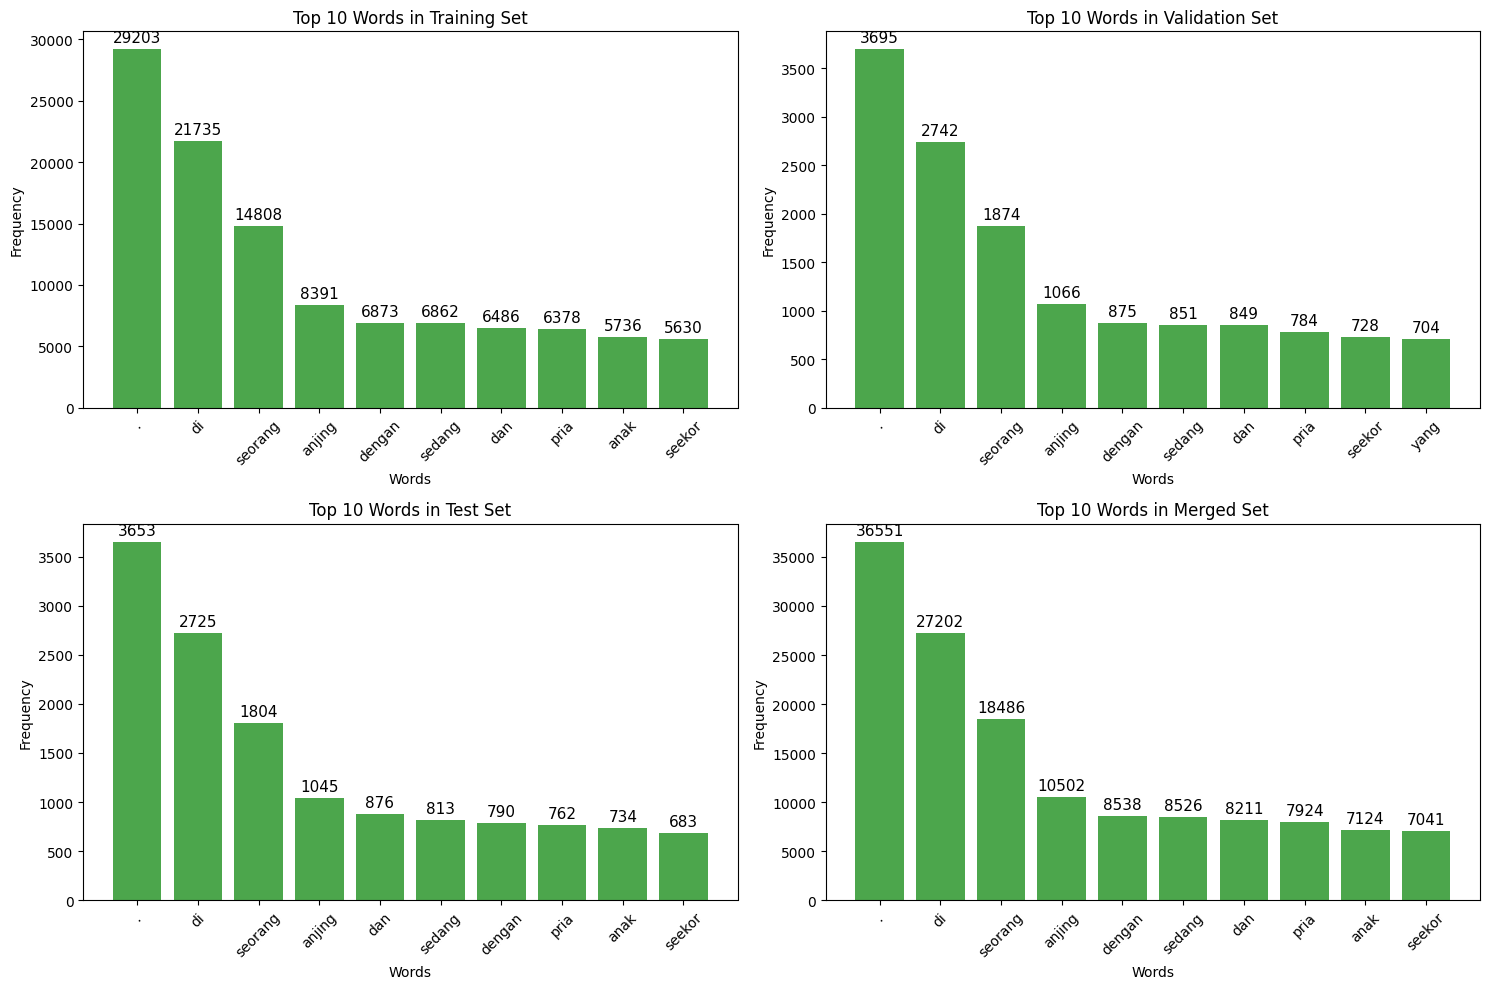

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('punkt')

# 2. Top 10 Most Frequent Words for all datasets
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, (dataset, label) in zip(axs.flatten(), datasets):
    # Tokenize each caption into words
    all_words = ' '.join(dataset['Caption']).lower()  # Combine all captions into one large string and convert to lower case
    words = nltk.word_tokenize(all_words)  # Tokenize into words
    
    # Count word frequencies
    word_counts = Counter(words)
    
    # Get the top 10 most common words
    top_words = word_counts.most_common(10)
    top_words, top_counts = zip(*top_words)  # Separate words and their counts

    # Plot the bar chart for the top 10 words
    ax.bar(top_words, top_counts, color='green', alpha=0.7)
    ax.set_title(f'Top 10 Words in {label}')
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
    
    # Adding count labels to the bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{top_counts[i]}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=11, color='black', 
                    xytext=(0, 5), 
                    textcoords='offset points')

plt.tight_layout()
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


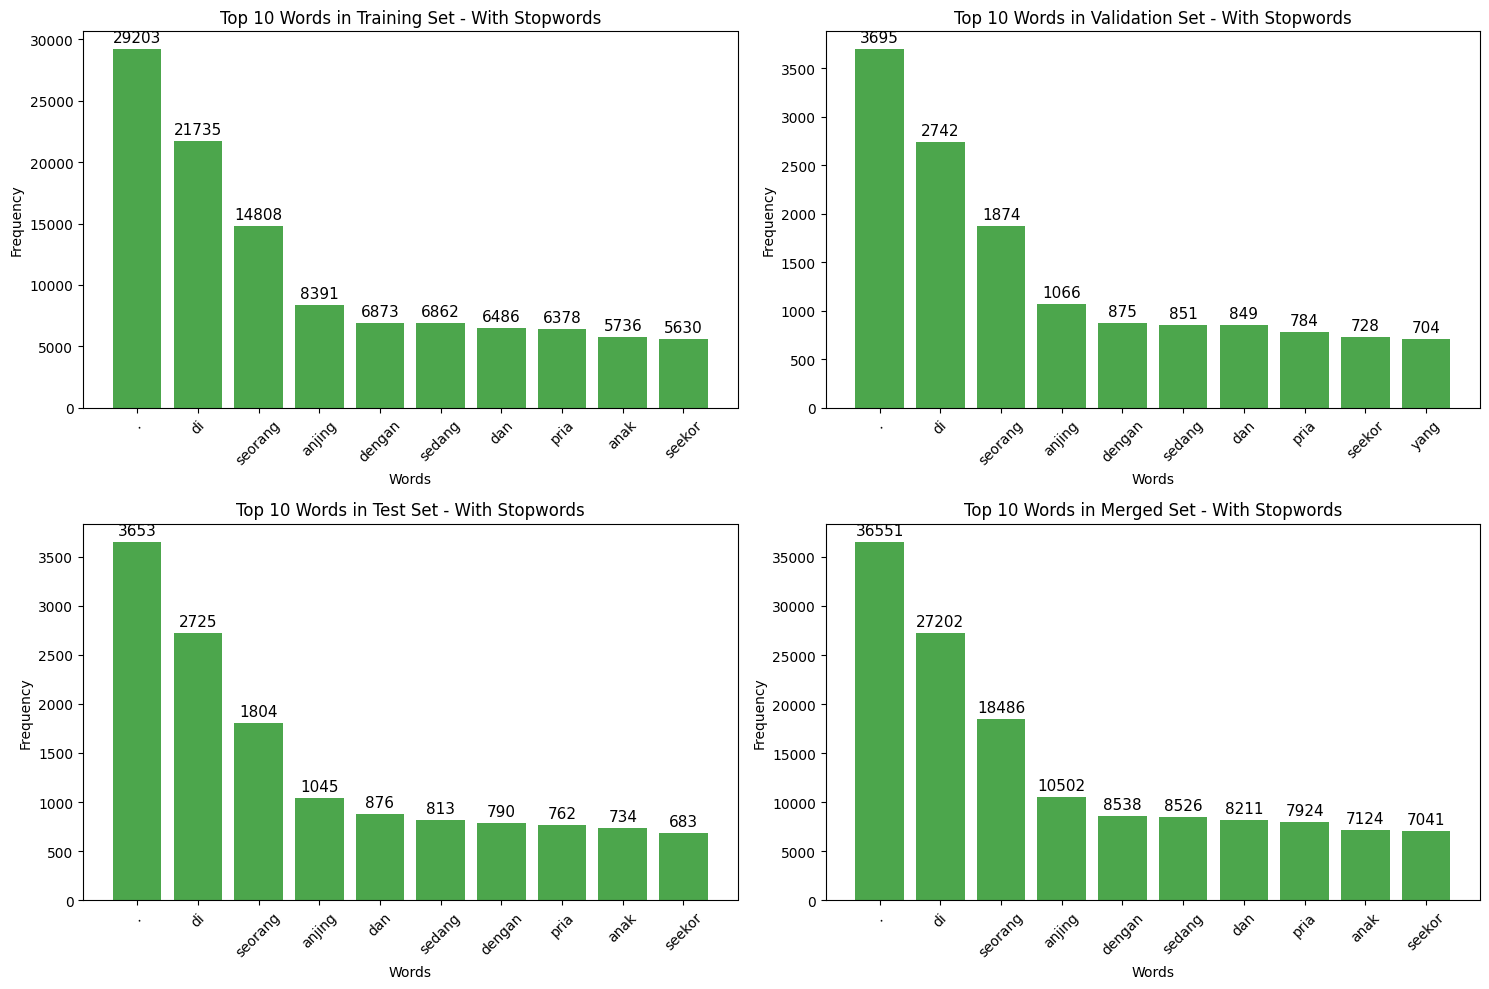

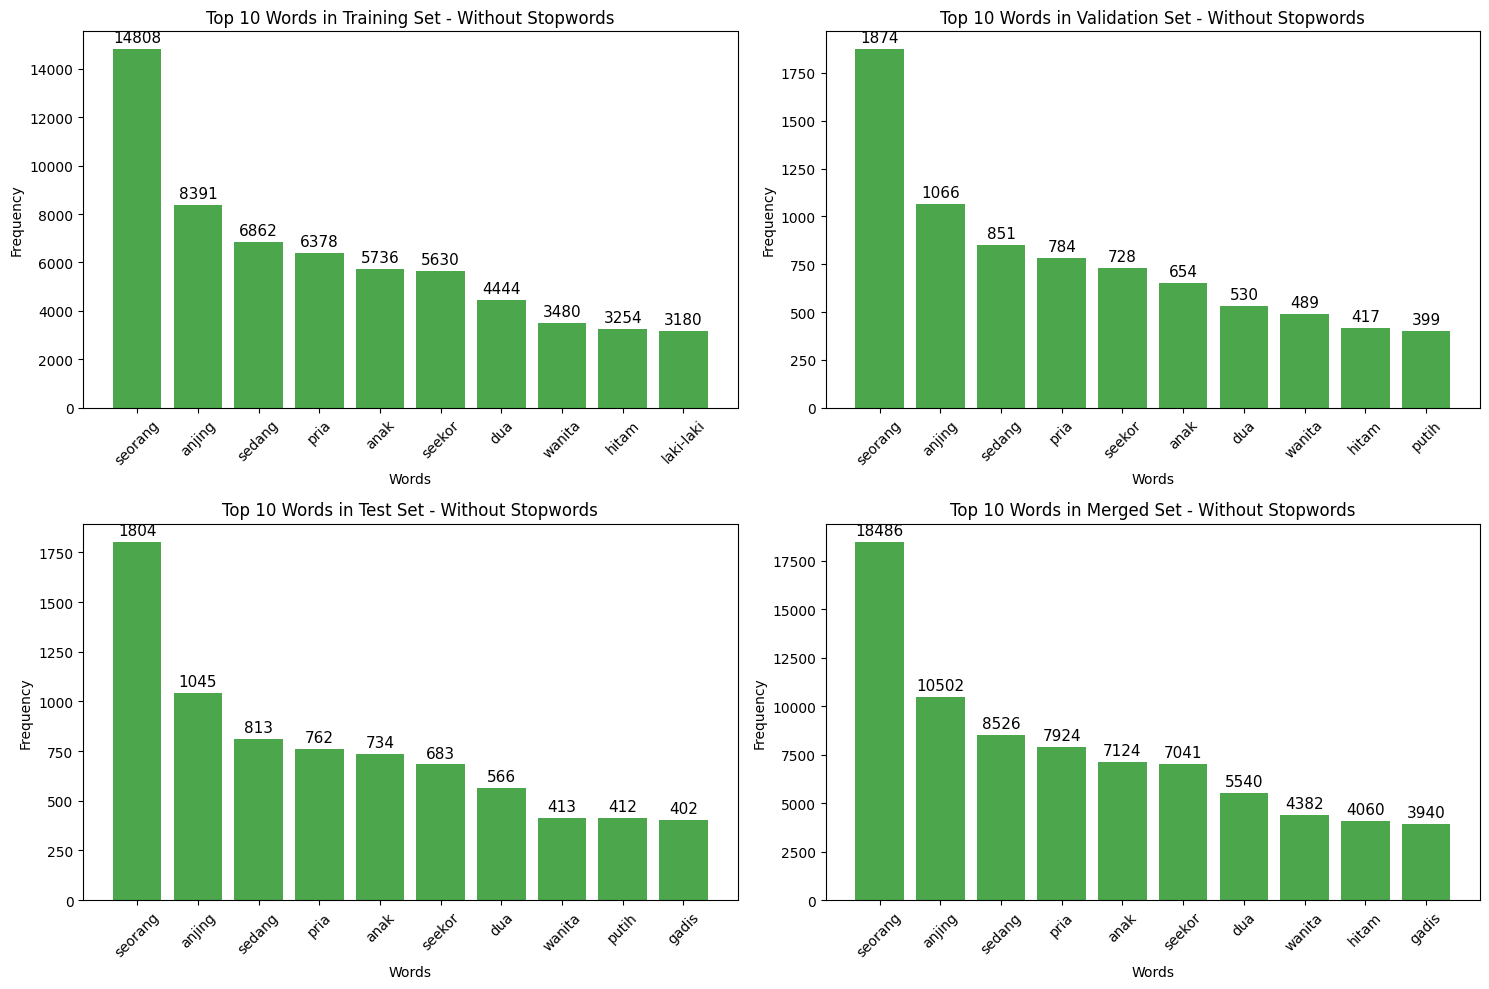

In [11]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import string

# Download required resources
nltk.download('punkt')

# Define Indonesian stopwords (for demo purpose, add more stopwords as needed)
indonesian_stopwords = set([
    "dan", "di", "ke", "dengan", "yang", "untuk", "pada", "itu", "ada", "ini", 
    "itu", "sebuah", "bagi", "dari", "mereka", "tersebut", "oleh", "bahwa", 
    "adalah", "sekarang", "sudah", "belum", "akan", "saja", "atau", "juga", 
    "maupun", "kembali", "seperti", "dalam", "setelah", "ketika", "sehingga"
])

# Function to remove stopwords
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    return [word for word in words if word.lower() not in indonesian_stopwords and word not in string.punctuation]

# Function to plot top 10 words with and without stopwords
def plot_top_words(datasets, stopword_removed=False):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for ax, (dataset, label) in zip(axs.flatten(), datasets):
        # Tokenize and remove stopwords if required
        if stopword_removed:
            all_words = ' '.join(dataset['Caption']).lower()
            words = remove_stopwords(all_words)  # Remove stopwords
        else:
            all_words = ' '.join(dataset['Caption']).lower()
            words = nltk.word_tokenize(all_words)  # No stopword removal, just tokenize

        # Count word frequencies
        word_counts = Counter(words)
        
        # Get the top 10 most common words
        top_words = word_counts.most_common(10)
        top_words, top_counts = zip(*top_words)  # Separate words and their counts

        # Plot the bar chart for the top 10 words
        ax.bar(top_words, top_counts, color='green', alpha=0.7)
        ax.set_title(f'Top 10 Words in {label} - {"Without" if stopword_removed else "With"} Stopwords')
        ax.set_xlabel('Words')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability

        # Adding count labels to the bars
        for i, p in enumerate(ax.patches):
            ax.annotate(f'{top_counts[i]}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='baseline', 
                        fontsize=11, color='black', 
                        xytext=(0, 5), 
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()

# Now we can call this function twice, once with stopwords and once without
datasets = [(df_train, 'Training Set'), (df_val, 'Validation Set'), (df_test, 'Test Set'), (df_merge, 'Merged Set')]

# Plot with stopwords
plot_top_words(datasets, stopword_removed=False)

# Plot without stopwords
plot_top_words(datasets, stopword_removed=True)

In [12]:
# 3. Number of images in training, validation, and test sets
print(f"Number of images: {len(df_merge)}")
print(f"Number of training images: {len(df_train)}")
print(f"Number of validation images: {len(df_val)}")
print(f"Number of test images: {len(df_test)}")

Number of images: 40455
Number of training images: 32364
Number of validation images: 4045
Number of test images: 4046


In [13]:
# 4. Sample Images and Captions
def plot_images_with_captions(dataset, dataset_title='', num_images=5):
    # Ambil random indices dari dataset
    random_indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(15, 5))
#     plt.suptitle(dataset_title, fontsize=16)  # Set overall title
    for i, idx in enumerate(random_indices):
        # Get the item from the dataset
        item = dataset.iloc[idx]
        caption = item['Caption']
        image_id = item['Images']

        plt.subplot(1, num_images, i + 1)  # Create subplot
        with Image.open(item['Path']) as image:
            plt.imshow(image)
        plt.axis('off')  # Hide axes
        
        # Wrap caption, CUI, and Ref CUI with line breaks
        wrapped_caption = textwrap.fill(caption, width=35)
        
        # Combine the wrapped text with extra line break
        wrapped_text = (f"ID: {image_id}\n\n"
                        f"Capt: {wrapped_caption}")
        
        plt.title(wrapped_text, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust title position
    plt.show()

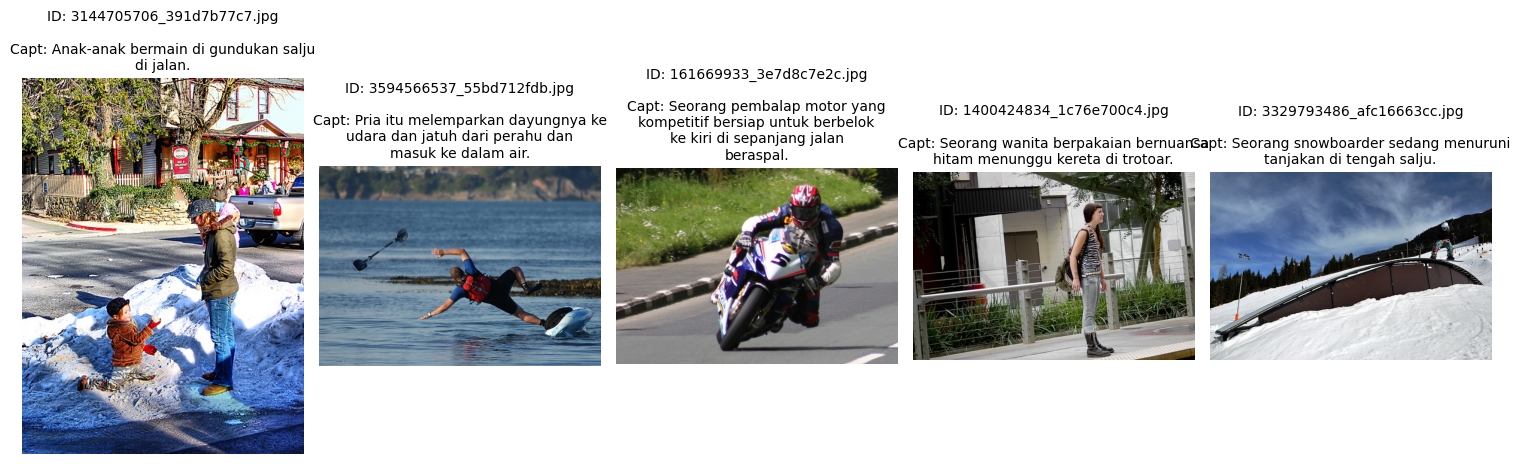

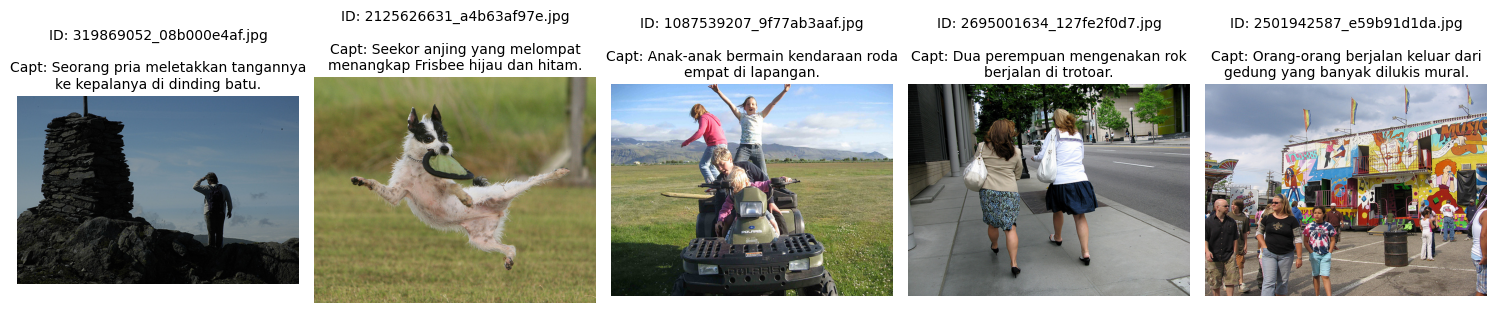

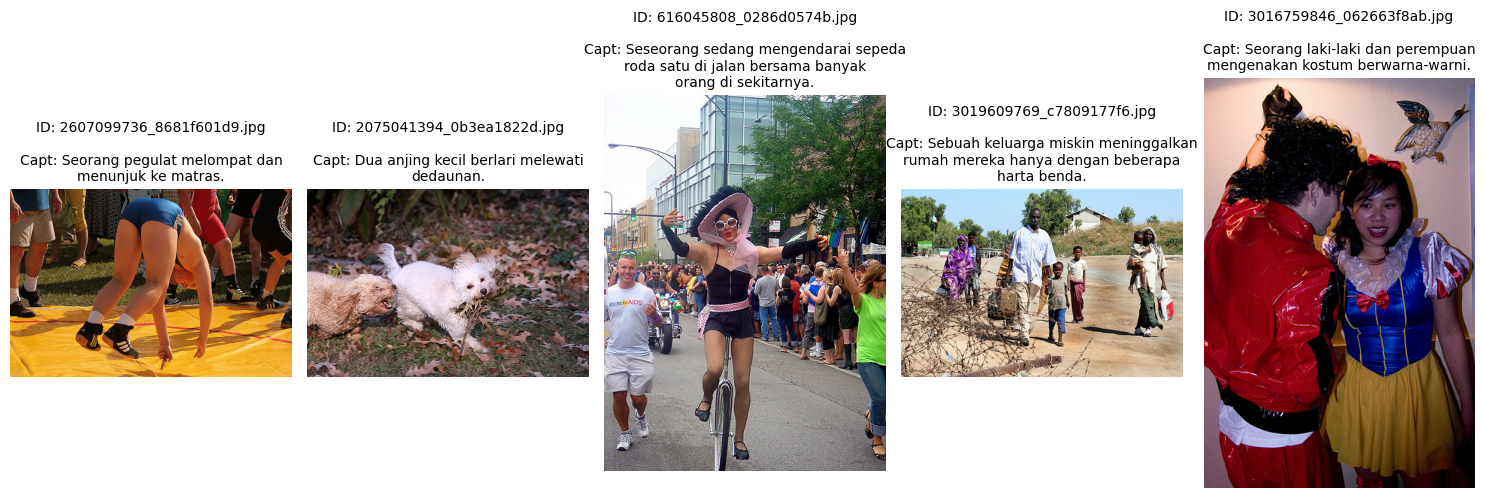

In [14]:
# Display 5 sample images and their captions
plot_images_with_captions(dataset=df_train, dataset_title='Train')
plot_images_with_captions(dataset=df_val, dataset_title='Val')
plot_images_with_captions(dataset=df_test, dataset_title='Test')

In [15]:
# 6. Frequency of Unique Captions
for dataset, label in datasets:
    unique_captions = dataset['Caption'].nunique()
    print(f"Number of unique captions in the {label}: {unique_captions}")

Number of unique captions in the Training Set: 31988
Number of unique captions in the Validation Set: 4037
Number of unique captions in the Test Set: 4035
Number of unique captions in the Merged Set: 39899


In [16]:
df_merge.to_csv("df_merge.csv")
df_merge

Images                                                                             Caption                                                                    Path  caption_length  num_words
0       359082432_c1fd5aa2d6.jpg  Seorang pria dan seekor anjing sedang berdiri di atas pohon yang tumbang ke tanah.   /kaggle/input/image-caption-indonesia/Images/359082432_c1fd5aa2d6.jpg              82         14
1      2460799229_ce45a1d940.jpg  Ketiga anak laki-laki yang mengenakan jaket pelampung sedang melihat ke dalam air.  /kaggle/input/image-caption-indonesia/Images/2460799229_ce45a1d940.jpg              82         12
2      3634828052_3b6aeda7d6.jpg     Seorang wanita dengan kamera dengan lensa yang sangat panjang mengambil gambar.  /kaggle/input/image-caption-indonesia/Images/3634828052_3b6aeda7d6.jpg              79         11
3      2216568822_84c295c3b0.jpg               Wanita dengan helm merah dan tato penduduk asli Amerika di lengannya.  /kaggle/input/image-caption-indonesia/Images/2216568822_84c295c3b0.jpg              69         11
4      3080056515_3013830309.jpg                                              Satu orang berbisik kepada orang lain.  /kaggle/input/image-caption-indonesia/Images/3080056515_3013830309.jpg              38          6
...                          ...                                                                                 ...                                                                     ...             ...        ...
40450  2703155733_19ac6f97a8.jpg                        Seorang wanita melepas jubah besar memperlihatkan gaun mewah  /kaggle/input/image-caption-indonesia/Images/2703155733_19ac6f97a8.jpg              60          8
40451   498794783_cc2ac62b47.jpg  Seorang gadis berpakaian sedang meniup gelembung dengan gadis lain di belakangnya.   /kaggle/input/image-caption-indonesia/Images/498794783_cc2ac62b47.jpg              82         11
40452  3317145805_071b15debb.jpg                            Seekor pudel hitam dengan mainan tali merah di mulutnya.  /kaggle/input/image-caption-indonesia/Images/3317145805_071b15debb.jpg              56          9
40453  2418191216_82711d5c5c.jpg                                      Seorang wanita tua memakai topi dan tersenyum.  /kaggle/input/image-caption-indonesia/Images/2418191216_82711d5c5c.jpg              46          7
40454  3163477256_073605e06e.jpg    Seorang kiper berseragam biru menangkap bola sepak oleh pemain berseragam merah.  /kaggle/input/image-caption-indonesia/Images/3163477256_073605e06e.jpg              80         11

[40455 rows x 5 columns]